## Words around male and characters and co-occurence matrix

In [1]:
import pandas as pd
import numpy as np 
import sklearn
import seaborn as sns
import pandas as pd
from pathlib import Path
import os
import sys
import csv
import numpy as np

import nltk                                                             # Natural language Toolkit
from nltk.stem import SnowballStemmer                                   # Porter's II Stemmer
from nltk import word_tokenize                                          # Document tokenizer
from nltk.corpus import stopwords  
#nltk.download('wordnet')
#nltk.download('omw-1.4')

from nltk.tokenize import word_tokenize 
import nltk
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import RegexpTokenizer

In [2]:
from pandas.core.common import flatten

## extract sentences with male names

the "Cinderella complex" paper (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6874350/): 
1. we select five words before and five words after the names of the leading characters across all the sentences. 
2. We iterate over the pairwise combinations of words within 10-word samples across all movie synopses to create a word co-occurrence matrix
3. construct word co-occurrence networks, one for females and the other for male

In [4]:
import os

In [5]:
df=pd.read_csv("/Users/pazma/Documents/BSE/text_mining/term_project/text_mining_termpaper/preprocessed_corpus.csv")

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
remove_pronouns=['he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself']
# stopwords = [word for word in remove_pronouns if word not in stopwords]

In [7]:
stopwords_wo_pronoun=list(set(stopwords)-set(remove_pronouns))

In [8]:
# split text to sentences
sentences=df["clean_text2"].apply(nltk.sent_tokenize)

In [9]:
sentences[0]

["[illustration] alice's adventures wonderland lewis carroll millennium fulcrum edition 3.0 contents   rabbit-hole   pool tears   caucus-race long tale   rabbit sends little bill   advice caterpillar   pig pepper   mad tea-party   queen's croquet-ground  ix.",
 "mock turtle's story   lobster quadrille   stole tarts?",
 'alice\'s evidence   rabbit-hole alice beginning get tired sitting her sister bank, nothing do: twice she peeped book her sister reading, pictures conversations it, "and use book," thought alice "without pictures conversations?"',
 'she considering her mind (as well she could, hot day made her feel sleepy stupid), whether pleasure making daisy-chain would worth trouble getting picking daisies, suddenly white rabbit pink eyes ran close her.',
 'nothing very remarkable that; alice think very much way hear rabbit say itself, "oh dear!',
 'oh dear!',
 'shall late!"',
 '(when she thought afterwards, occurred her she ought wondered this, time seemed quite natural); rabbit actu

In [16]:
# import female and male character names lists

male_characters = open("/Users/pazma/Documents/BSE/text_mining/term_project/male_character_names.txt", "r")

male_characters = male_characters.read().splitlines()

In [17]:
from pandas.core.common import flatten
# token_new_author_list=list(flatten([w.split() for w in new_author_list]))
puncts=[")", "(", ",", ".", "?", "!", "[", "]", ";", "''","'s", "`", "'ve", "'re", "'ll",
       "ix", "x", "v", "i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "xi", "xii", 
       "xiii", "xiv", "xv", "xvi", "xvii", "xviii", "xix"]

In [18]:
# clean sentences
lemmatiser = WordNetLemmatizer()

clean_sentences_all=[]
for i in range(len(sentences)): 
    clean_sentences=[]
    for j in range(len(sentences[i])):
        #lemmatize
        lemm_sentence=[lemmatiser.lemmatize(token.lower(), pos='v') for token in nltk.word_tokenize(sentences[i][j])]
        lemm_sentence_clean=[]
        # remove stopwords
        for word in lemm_sentence:
            if word not in stopwords_wo_pronoun:
                lemm_sentence_clean.append(word)
       #  # remove authors' names
       #  lemm_sentence_clean2=[]
       #  for word in lemm_sentence_clean:
       #      if word not in token_new_author_list:
       #          lemm_sentence_clean2.append(word)
                
        # remove punctuations
        lemm_sentence_clean3=[]
        for word in lemm_sentence_clean:
            if word not in puncts:
                lemm_sentence_clean3.append(word)
        # POS tag and keep only nouns, verbs, adjectives and pronouns
        pos_=nltk.pos_tag(lemm_sentence_clean3)

        pos_=[s for s in pos_ if (s[1] == 'JJ')|
        (s[1] == "JJR")|
        (s[1] == "JJS")|      
        (s[1] == "VB" )|
        (s[1] == "VBD")|
        (s[1] == "VBG")|
        (s[1] == "VBN")|
        (s[1] == "VBP")|
        (s[1] == "VBZ")|
        (s[1] == "NN" )|
        (s[1] == "NNP")|
        (s[1] == "NNS")|
        (s[1] == "NNPS")|
             (s[1] == "PRP")|
             (s[1] == "PRP$")]

        lemm_sentence_clean3=[x[0] for x in pos_]
        # join back
        clean_sent=' '.join(lemm_sentence_clean3)
        clean_sentences.append(clean_sent)
    clean_sentences_all.append(clean_sentences)



### Male characters

We basically need to obtain the sentences that contain the female characters' names + pronouns and then do a frequency count of those words or if we are working with domain list (which we will do) then after calculating the frequenc of each word we can filter the words based on the domain lists and aggregate frequencies by groups.

In [19]:
male_characters[:10]

['shea',
 'austen',
 'griff',
 'abram',
 'bennet',
 'rudolph',
 'darrell',
 'osmond',
 'michele',
 'christopher']

In [20]:
# replace male character names with she
male_sentences_replaced=[]
male_set = set(male_characters)
for i in range(len(clean_sentences_all)):
    sent_temp=[]
    for j in range(len(clean_sentences_all[i])):
        final_string = ' '.join("he" if i in male_set else i for i in clean_sentences_all[i][j].split())
        sent_temp.append(final_string)
    male_sentences_replaced.append(sent_temp)

In [21]:
def ten_neighbours(pronoun, list_):
    
    """
    extract 5 words before and 5 words after a female word
    
    """
    idx = list_.index(pronoun) # save location of pronoun
    words = list_[:] # copy list into new variable so we don't change it
    words.remove(pronoun) # remove all pronouns from the list 
    left_slice = idx-5 # start of range
    left_slice = min(max(0,left_slice),len(words)-6) # account for edges
    right_slice = left_slice+6 # end of range is straightforward now
    return words[left_slice:right_slice]

In [22]:
he_pronouns=["he", "his", "him", "himself"]


In [24]:
extra_punct=["``", "-", ":", "'", "--"]
male_sentences_all_together=list(flatten(male_sentences_replaced))
male_words_all=[]
for pronoun in he_pronouns:
    remaining_she_pronouns=he_pronouns.copy()
    remaining_she_pronouns.remove(pronoun)
    for sent in male_sentences_all_together:        
        try: 
            s=sent.split()
            s=[word for word in s if word not in remaining_she_pronouns] # remove male pronouns from the sentence
            s=[word for word in s if word not in extra_punct] # remove remaining punctuations            
            male_words_all.append(ten_neighbours(pronoun, s))
            
        except ValueError:  # if there is no pronoun in the sentence, jump to next one
            continue
    

In [25]:
print(len(male_words_all)), print(male_words_all[:3])

1948010
[['illustration', 'alice', 'adventure', 'wonderland', 'he', 'millennium'], ['sleepy', 'stupid', 'pleasure', 'make', 'daisy-chain', 'trouble'], ['nothing', 'remarkable', 'alice', 'think', 'much', 'hear']]


(None, None)

In [26]:
# word frequencies around male words
from collections import Counter

male_word_counts = Counter(list(flatten(male_words_all)))
male_word_counts=male_word_counts.most_common()
male_word_counts[:10]

[('he', 474451),
 ('she', 100565),
 ('go', 99543),
 ('her', 96173),
 ('come', 75397),
 ('make', 62488),
 ('take', 60538),
 ('know', 58691),
 ('look', 57384),
 ('get', 55627)]

In [28]:
# export male words list
male_words=list(flatten(male_words_all))
with open('male_words.txt', 'w') as f:
    for item in male_words:
        f.write("%s\n" % item)

In [65]:
male_words_df=pd.DataFrame(male_word_counts, columns=["term", "freq"])
male_words_df.to_csv("male_words_df.csv")

In [66]:
# drop rows with pronouns
male_words_df["pron"]=np.where((male_words_df["term"]=="she")|
                        (male_words_df["term"]=="he")|
                        (male_words_df["term"]=="her")|
                        (male_words_df["term"]=="his")|
                       (male_words_df["term"]=="hers")|
                       (male_words_df["term"]=="herself")|
                       (male_words_df["term"]=="himself")|
                       (male_words_df["term"]=="mr")|
                       (male_words_df["term"]=="mrs.")|
                       (male_words_df["term"]=="mrs")|                       
                        (male_words_df["term"]=="mr."),1,0)
male_words_df_wo_pron=male_words_df[male_words_df["pron"]==0]


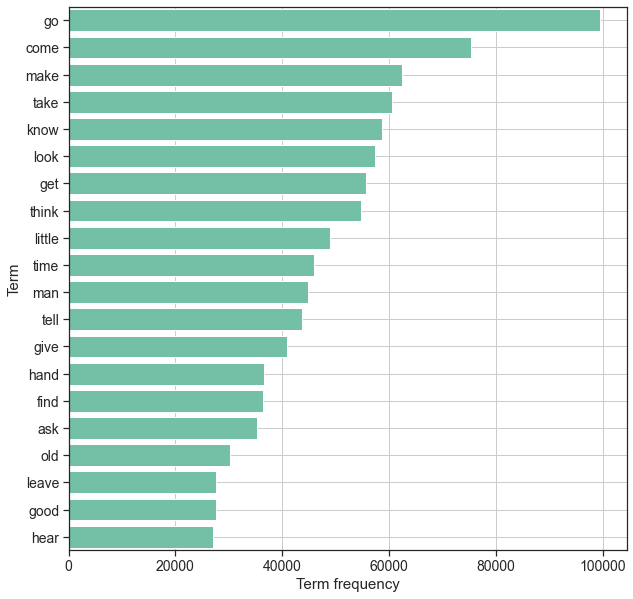

In [74]:
# Visualize 
vis_df=male_words_df_wo_pron[:20]
import seaborn as sns
sns.set(style="ticks")
# sns.set_palette("pastel")
plt.figure(figsize=(10,10))
p=sns.barplot(x="freq", y="term",color="mediumaquamarine", data=vis_df)
plt.grid()
plt.xlabel("Term frequency", fontsize=15)
plt.ylabel("Term", fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

## Co-occurence matrix  + community detection with the modularity algorithm  

In [29]:
# pairwise combinations by sentences
pair_list_all=[]
# importing required library
import itertools

for i in range(len(male_words_all)):
    # creating a list of elements belonging to integers and strings
    lst = male_words_all[i]

    # simulating permutations of the list in a group of 2
    pair_order_list = itertools.combinations(lst, 2)

    # printing the elements belonging to permutations
    pair_list=list(pair_order_list)

    pair_list_all.append(pair_list)

In [30]:
pair_list_all[0]+=pair_list_all[1]

i=2
while i<=len(pair_list_all):
    pair_list_all[0]+=pair_list_all[i]
    i+=1


**This error above is not an error, it just means that the while loop has stopped.** 

In [32]:
pairwise_combos=pair_list_all[0]

In [33]:
frequency_list = Counter(tuple(sorted(i)) for i in pairwise_combos)
matrix=pd.DataFrame(frequency_list.items())


In [34]:
matrix.columns=["bigram", "freq"]

In [35]:
matrix

,bigram,freq
0,"(alice, illustration)",5
1,"(adventure, illustration)",7
2,"(illustration, wonderland)",1
3,"(he, illustration)",851
4,"(illustration, millennium)",1
...,...,...
4729704,"(aforesaid, invite)",1
4729705,"(aforesaid, race)",1
4729706,"(himself, player)",1
4729707,"(himself, tackle)",1


In [36]:
matrix[['b1', 'b2']] = pd.DataFrame(matrix['bigram'].tolist(), index=matrix.index)
matrix

,bigram,freq,b1,b2
0,"(alice, illustration)",5,alice,illustration
1,"(adventure, illustration)",7,adventure,illustration
2,"(illustration, wonderland)",1,illustration,wonderland
3,"(he, illustration)",851,he,illustration
4,"(illustration, millennium)",1,illustration,millennium
...,...,...,...,...
4729704,"(aforesaid, invite)",1,aforesaid,invite
4729705,"(aforesaid, race)",1,aforesaid,race
4729706,"(himself, player)",1,himself,player
4729707,"(himself, tackle)",1,himself,tackle


In [37]:
# export female co-occurence df
matrix.to_csv("male_co_matrix.csv")


In [38]:
# drop rows with pronouns
matrix["pron"]=np.where((matrix["b1"]=="she")|
                        (matrix["b1"]=="he")|
                        (matrix["b1"]=="her")|
                        (matrix["b1"]=="his")|
                       (matrix["b1"]=="hers")|
                       (matrix["b1"]=="herself")|
                       (matrix["b1"]=="himself")|
                       (matrix["b1"]=="mr")|
                       (matrix["b1"]=="mrs.")|
                       (matrix["b1"]=="mrs")|
                       (matrix["b2"]=="she")|
                        (matrix["b2"]=="he")|
                        (matrix["b2"]=="her")|
                        (matrix["b2"]=="his")|
                       (matrix["b2"]=="hers")|
                       (matrix["b2"]=="herself")|
                       (matrix["b2"]=="himself")|
                       (matrix["b2"]=="mr")|
                       (matrix["b2"]=="mrs.")|
                        (matrix["b2"]=="mr.")|
                        (matrix["b1"]=="mr.")|
                       (matrix["b2"]=="mrs"),1,0)
matrix_wo_pron=matrix[matrix["pron"]==0]

In [39]:
matrix_wo_pron.to_csv("filtered_wopron_male_matrix.csv")

In [40]:
import networkx as nx
matrix_nx=matrix_wo_pron[["b1", "b2", "freq"]]
matrix_nx.columns=["source", "target", "weight"]


In [41]:
matrix_nx

,source,target,weight
0,alice,illustration,5
1,adventure,illustration,7
2,illustration,wonderland,1
4,illustration,millennium,1
5,adventure,alice,4
...,...,...,...
4729701,aforesaid,water,1
4729702,aforesaid,matter,1
4729703,aforesaid,stranger,1
4729704,aforesaid,invite,1


In [42]:
# get first 300 most common word pairs 
matrix_nx=matrix_nx.sort_values(by="weight", ascending=False)
matrix_nx=matrix_nx[:300]

In [43]:
G = nx.from_pandas_edgelist(matrix_nx, edge_attr='weight')

In [44]:
import matplotlib.pyplot as plt

In [83]:
os.getcwd()

'/Users/pazma/Documents/BSE/text_mining/term_project/text_mining_termpaper/code'

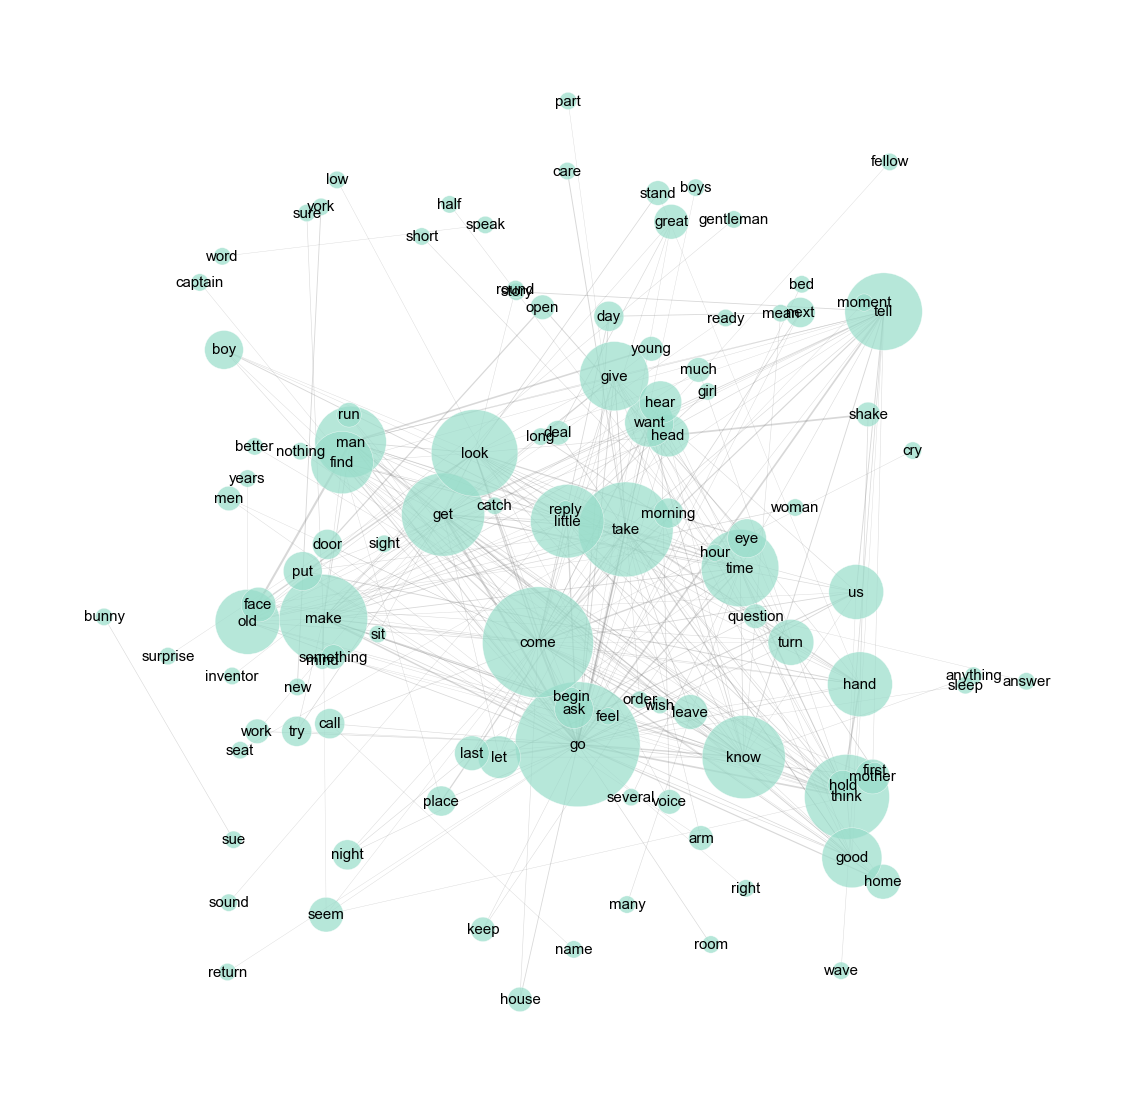

In [82]:
widths = nx.get_edge_attributes(G, 'weight')
for key in widths:    
    widths[key] *=  0.0005
    
d = dict(G.degree)
    
nodelist = G.nodes()

plt.figure(figsize=(20,20))

pos = nx.spring_layout(G, k=0.999, iterations=1)
G.remove_edges_from(nx.selfloop_edges(G))
nodes=nx.draw_networkx_nodes(G,pos,
                       #nodelist=nodelist,
                       node_size=[v * 300 for v in d.values()],
                       node_color='#98ddca', linewidths=0.5,
                       alpha=0.7)
nodes.set_edgecolor('white')
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='grey', alpha=0.3
                       )
nx.draw_networkx_labels(G, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        font_color='black', 
                       font_size=15)
plt.box(False)
plt.savefig("male_words_network.png", format="PNG")
plt.show()

### Communities

In [54]:
import matplotlib.cm
import community as community_louvain

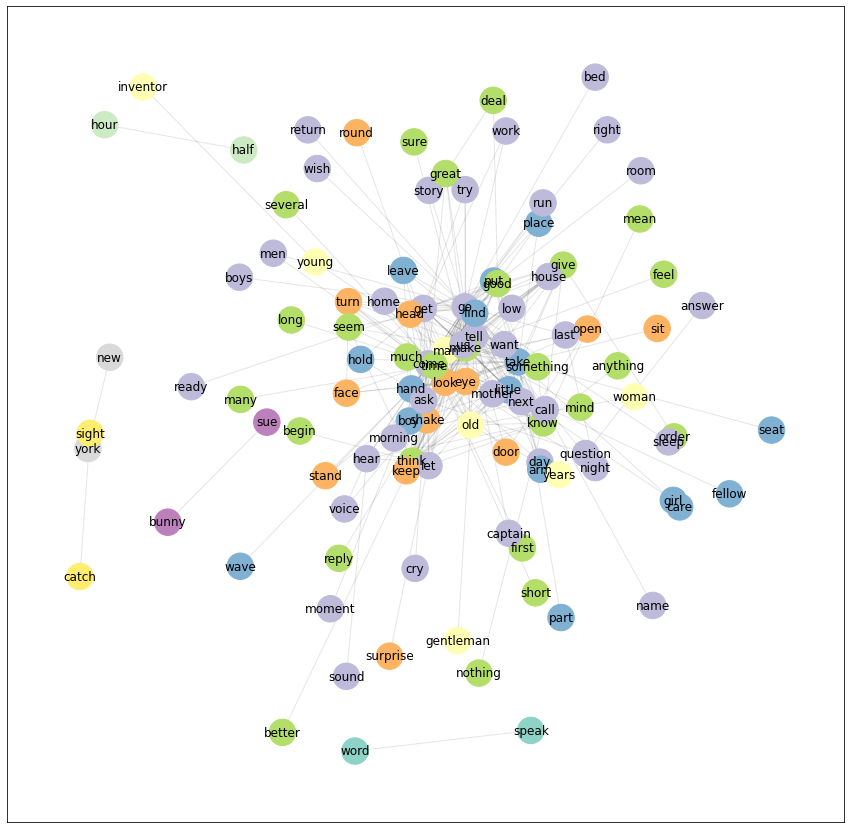

In [55]:
partition = community_louvain.best_partition(G)
# draw the graph
pos = nx.spring_layout(G, k=0.99, iterations=5)
# color the nodes according to their partition
cmap = matplotlib.cm.get_cmap('Set3', max(partition.values()) + 1)
plt.figure(figsize=(15,15))
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=700,
                   cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G,pos, alpha=0.1)
plt.show()

In [56]:
import networkx.algorithms.community as nxcom
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
len(communities)



12

In [57]:
node_to_community = community_louvain.best_partition(G)
values=list(node_to_community.keys())
node_labels_=dict(zip(values, values))

In [60]:
list(np.unique(list(node_to_community.values())))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [59]:
from mycolorpy import colorlist as mcp
import numpy as np
color1=mcp.gen_color(cmap="Set3",n=len(np.unique(list(node_to_community.values()))))
print(color1)

['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', '#80b1d3', '#b3de69', '#fccde5', '#d9d9d9', '#bc80bd', '#ccebc5', '#ffed6f']


In [61]:
community_to_color=dict(zip(list(np.unique(list(node_to_community.values()))), color1))

/Users/pazma/opt/anaconda3/lib/python3.8/site-packages/netgraph/_node_layout.py:1018: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")
/Users/pazma/opt/anaconda3/lib/python3.8/site-packages/netgraph/_edge_layout.py:761: RuntimeWarning: invalid value encountered in true_divide
  displacement = compatibility * delta / distance_squared[..., None]


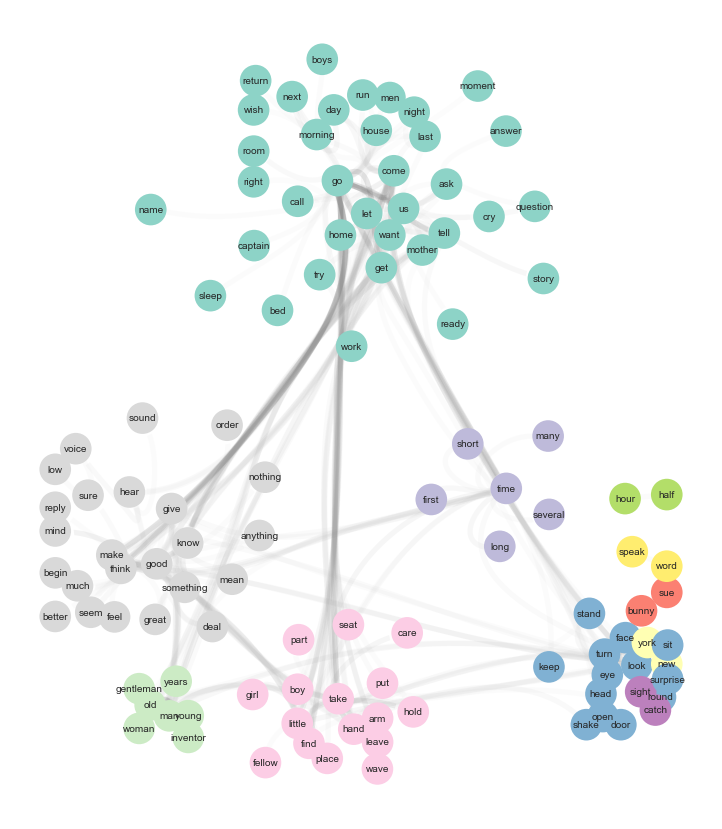

In [84]:
# # alternatively, we can visualize the communities more together
from netgraph import Graph

node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

plt.figure(figsize=(15,15))
Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000), node_labels=node_labels_, 
      node_label_fontdict=dict(size=10)
)
plt.savefig("male_words_communities.png", format="PNG")
plt.show()